In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === LOAD & PREPARE DATA ===
df = pd.read_csv("NIFTY 50_minute_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()
df = df.loc['2020-01-01':'2025-03-31']
df = df[~df.index.duplicated(keep='first')]

# === RESAMPLE TO 1H ===
df_1h = df.resample('1h').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()
print(df_1h)

# === SAVE TO CSV ===
df_1h.to_csv('NIFTY 50_hourly_data.csv')


                         open      high       low     close  volume
date                                                               
2020-01-01 09:00:00  12202.15  12222.05  12191.45  12200.50       0
2020-01-01 10:00:00  12200.65  12201.20  12170.00  12177.35       0
2020-01-01 11:00:00  12177.60  12187.15  12172.55  12175.95       0
2020-01-01 12:00:00  12175.40  12193.15  12165.40  12182.80       0
2020-01-01 13:00:00  12182.85  12197.75  12171.75  12190.60       0
...                       ...       ...       ...       ...     ...
2025-02-07 11:00:00  23611.90  23694.50  23608.35  23646.60       0
2025-02-07 12:00:00  23647.00  23653.45  23550.25  23557.35       0
2025-02-07 13:00:00  23555.70  23591.40  23487.35  23511.25       0
2025-02-07 14:00:00  23510.75  23530.05  23443.20  23490.30       0
2025-02-07 15:00:00  23490.80  23591.25  23490.80  23563.15       0

[8865 rows x 5 columns]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
from scipy.signal import argrelextrema



# EMD
#pseudo def, for code running
def snr(data, noise):
    # return 0
    if (len(noise))==0:
        return 0
    return np.sqrt(np.sum(data**2)/np.sum(noise**2))*0.000
# correlation points of upper and lower envelope
def max_min_peaks(data, point_type:str = "emd"):
    assert(point_type in ["emd", "ext", "mid"])
    emd_id = {"emd": 1, "ext": 2, "mid": 3}
    point_type = emd_id[point_type]

    point_num = np.size(data)
    peaks_max = signal.argrelextrema(data, np.greater)[0]
    peaks_min = signal.argrelextrema(data, np.less)[0]

    if point_type > 1:
        peaks_max = np.concatenate(([0], peaks_max, [point_num-1]))
        peaks_min = np.concatenate(([0], peaks_min, [point_num-1]))

    if point_type > 2:
        _tmp = np.sort(np.concatenate(([0], peaks_max, peaks_min, [point_num-1])))
        _tmp = np.delete(_tmp, np.where(_tmp[1:] == _tmp[:-1]))
        mid_point = []
        for i in range(_tmp.shape[0] - 1):
            mid_point.append(int((_tmp[i]+_tmp[i+1]) / 2))

        peaks_max = np.sort(np.concatenate((peaks_max, mid_point)))
        peaks_min = np.sort(np.concatenate((peaks_min, mid_point)))

    peaks_max = np.delete(peaks_max, np.where(peaks_max[1:] == peaks_max[:-1]))
    peaks_min = np.delete(peaks_min, np.where(peaks_min[1:] == peaks_min[:-1]))

    return peaks_max, peaks_min

# cubic interpolation sampling for less than 4 points
def cubic_spline_3pts(x, y, T):
    """
    Apparently scipy.interpolate.interp1d does not support
    cubic spline for less than 4 points.
    """
    x0, x1, x2 = x
    y0, y1, y2 = y

    x1x0, x2x1 = x1 - x0, x2 - x1
    y1y0, y2y1 = y1 - y0, y2 - y1
    _x1x0, _x2x1 = 1.0 / x1x0, 1.0 / x2x1

    m11, m12, m13 = 2 * _x1x0, _x1x0, 0
    m21, m22, m23 = _x1x0, 2.0 * (_x1x0 + _x2x1), _x2x1
    m31, m32, m33 = 0, _x2x1, 2.0 * _x2x1

    v1 = 3 * y1y0 * _x1x0 * _x1x0
    v3 = 3 * y2y1 * _x2x1 * _x2x1
    v2 = v1 + v3

    M = np.array([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])
    v = np.array([v1, v2, v3]).T
    k = np.array(np.linalg.inv(M).dot(v))

    a1 = k[0] * x1x0 - y1y0
    b1 = -k[1] * x1x0 + y1y0
    a2 = k[1] * x2x1 - y2y1
    b2 = -k[2] * x2x1 + y2y1

    t = T
    t1 = (T[np.r_[T < x1]] - x0) / x1x0
    t2 = (T[np.r_[T >= x1]] - x1) / x2x1
    t11, t22 = 1.0 - t1, 1.0 - t2

    q1 = t11 * y0 + t1 * y1 + t1 * t11 * (a1 * t11 + b1 * t1)
    q2 = t22 * y1 + t2 * y2 + t2 * t22 * (a2 * t22 + b2 * t2)
    q = np.append(q1, q2)

    return t, q

# cubic interpolation sampling for more than 3 points
def envelopes(data, peaks_max, peaks_min):
    point_num = len(data)

    if len(peaks_max) > 3:
        inp_max = interpolate.splrep(peaks_max, data[peaks_max], k=3)
        fit_max = interpolate.splev(np.arange(point_num), inp_max)
    else:
        _, fit_max = cubic_spline_3pts(peaks_max, data[peaks_max], np.arange(len(data)))

    if len(peaks_min) > 3:
        inp_min = interpolate.splrep(peaks_min, data[peaks_min], k=3)
        fit_min = interpolate.splev(np.arange(point_num), inp_min)
    else:
        _, fit_min = cubic_spline_3pts(peaks_min, data[peaks_min], np.arange(len(data)))

    return fit_max, fit_min

# determine if modal decomposition is over
def imf_judge(x: np.array, y: np.array):
    """
    x: The sequence after decomposition.
    y: The sequence before decomposition.
    """
    if (y.max() - y.min()) != 0 and ((x - y)**2).sum() / (y.max() - y.min()) < 0.001:
        return True

    if not np.any(x == 0) and (((x - y) / x)**2).sum() < 0.2:
        return True

    if (y**2).sum() != 0 and ((x - y)**2).sum() / (y**2).sum() < 0.2:
        return True

    return False

# Empirical Mode Decomposition (EMD)
def emd(signal):
    origin_signal = signal.copy()
    # extrema point
    emd_peaks_max, emd_peaks_min = max_min_peaks(signal, "emd")
    # print ('sig ',signal,'max_peak ',emd_peaks_max)

    # emd
    std_continue, old_std = 0, 0.0
    # envelope line
    emd_up_envelopes, emd_down_envelopes = 0, 0
    continue_time = 511

    while True:
        # number of extreme points
        if len(emd_peaks_max) < 3 or len(emd_peaks_min) < 3:
            break

        fit_max, fit_min = envelopes(signal, emd_peaks_max, emd_peaks_min)
        emd_up_envelopes, emd_down_envelopes = emd_up_envelopes + fit_max, emd_down_envelopes + fit_min
        signal_old = signal.copy()
        signal = signal - (fit_max + fit_min) / 2

        emd_peaks_max, emd_peaks_min = max_min_peaks(signal, "emd")
        pass_zero = np.sum(signal[:-1] * signal[1:] < 0)

        std = abs((fit_max + fit_min) / 2 / origin_signal).mean()
        std_continue = (std_continue << 1) & continue_time
        std_continue += 1 if abs(old_std - std) < 1e-6 else 0
        old_std = std

        if (abs(pass_zero - len(emd_peaks_max) - len(emd_peaks_min)) < 2) or imf_judge(signal, signal_old) or std_continue == continue_time:
            break

    if isinstance(emd_up_envelopes, int) and isinstance(emd_down_envelopes, int):
        return signal, signal
    return emd_up_envelopes, emd_down_envelopes

# Extrema Empirical Mode Decomposition (extemd)
def extemd(signal):
    origin_signal = signal.copy()
    # extrema point
    emd_peaks_max, emd_peaks_min = max_min_peaks(signal, "ext")

    # emd
    std_continue, old_std = 0, 0.0
    # envelope line
    emd_up_envelopes, emd_down_envelopes = 0, 0
    continue_time = 511

    while True:
        # number of extreme points
        if len(emd_peaks_max) < 3 or len(emd_peaks_min) < 3:
            break

        fit_max, fit_min = envelopes(signal, emd_peaks_max, emd_peaks_min)
        emd_up_envelopes, emd_down_envelopes = emd_up_envelopes + fit_max, emd_down_envelopes + fit_min
        signal_old = signal.copy()
        signal = signal - (fit_max + fit_min) / 2

        emd_peaks_max, emd_peaks_min = max_min_peaks(signal, "ext")
        pass_zero = np.sum(signal[:-1] * signal[1:] < 0)

        std = abs((fit_max + fit_min) / 2 / origin_signal).mean()
        std_continue = (std_continue << 1) & continue_time
        std_continue += 1 if abs(old_std - std) < 1e-6 else 0
        old_std = std

        if (abs(pass_zero - len(emd_peaks_max) - len(emd_peaks_min)) < 2) or imf_judge(signal, signal_old) or std_continue == continue_time:
            break

    if isinstance(emd_up_envelopes, int) and isinstance(emd_down_envelopes, int):
        return signal, signal
    return emd_up_envelopes, emd_down_envelopes

# Aliased Complete Ensemble Empirical Mode Decomposition (ACEEMD)
def aceemd(extsignal, midsignal, alpha = 0.5):
    origin_signal = extsignal.copy()
    # extrema point
    ext_peaks_max, ext_peaks_min = max_min_peaks(extsignal, "ext")
    mid_peaks_max, mid_peaks_min = max_min_peaks(midsignal, "mid")

    # emd
    std_continue, old_std = 0, 0.0
    # envelope line
    ext_up_envelopes, ext_down_envelopes = 0, 0
    mid_up_envelopes, mid_down_envelopes = 0, 0
    continue_time = 511

    while True:

        if len(ext_peaks_max) < 3 or len(ext_peaks_min) < 3:
            break


        fit_max, fit_min = envelopes(midsignal, mid_peaks_max, mid_peaks_min)
        mid_up_envelopes, mid_down_envelopes = mid_up_envelopes + fit_max, mid_down_envelopes + fit_min
        midsignal = midsignal - (fit_max + fit_min) / 2

        mid_peaks_max, mid_peaks_min = max_min_peaks(midsignal, "mid")


        fit_max, fit_min = envelopes(extsignal, ext_peaks_max, ext_peaks_min)
        ext_up_envelopes, ext_down_envelopes = ext_up_envelopes + fit_max, ext_down_envelopes + fit_min
        extsignal_old = extsignal.copy()
        extsignal = extsignal - (fit_max + fit_min) / 2

        ext_peaks_max, ext_peaks_min = max_min_peaks(extsignal, "ext")

        pass_zero = np.sum(extsignal[:-1] * extsignal[1:] < 0)

        std = abs((fit_max + fit_min) / 2 / origin_signal).mean()
        std_continue = (std_continue << 1) & continue_time
        std_continue += 1 if abs(old_std - std) < 1e-6 else 0
        old_std = std

        if (abs(pass_zero - len(ext_peaks_max) - len(ext_peaks_min)) < 2) or imf_judge(extsignal, extsignal_old) or std_continue == continue_time:
            break

    if isinstance(ext_up_envelopes, int) and isinstance(mid_up_envelopes, int) and isinstance(ext_down_envelopes, int) and isinstance(mid_down_envelopes, int):
        return signal, signal
    return ext_up_envelopes * (1-alpha) + mid_up_envelopes * alpha, ext_down_envelopes * (1-alpha) + mid_down_envelopes * alpha







class EMD_dealt:
    def __init__(self, source_data: np.array, emd_type: int=3, imf_times: int=10):
        '''
        :param source_data: three-dimensional data, respectively, batch size, number of days, data per stock
        :param emd_type: the emd type, 1->iceemd, 2->eceemd, 3->aceemd (default)
        '''
        #  Gaussian noise
        noise_list = []
        win_len = source_data.shape[-2]
        for _ in range(imf_times // 2):
            noise = np.random.randn(win_len)
            n_up_envelopes, n_down_envelopes = emd(noise)
            noise_list.append((n_up_envelopes + n_down_envelopes) / 2 / np.std(noise))

            n_up_envelopes, n_down_envelopes = emd(-noise)
            noise_list.append((n_up_envelopes + n_down_envelopes) / 2 / np.std(-noise))

        # emd process
        emd_result = []
        for s in range(len(source_data)):
            emd_tmp = []
            for d in range(len(source_data[s].T)):
                _data = (source_data[s].T)[d]
                # envelope line
                up_list, down_list = [], []
                # iceemd & eceemd
                if emd_type == 1 or emd_type == 2:
                    for noise in noise_list:
                        _emd_data = _data.copy() + noise * snr(_data, noise)
                        up, down = emd(_emd_data) if emd_type == 1 else extemd(_emd_data)

                        up_list.append(up)
                        down_list.append(down)
                # aceemd
                else:
                    for i in range(imf_times // 2):
                        _exemd_data = _data.copy() + noise_list[2*i] * snr(_data, noise_list[2*i])
                        _acemd_data = _data.copy() + noise_list[2*i+1] * snr(_data, noise_list[2*i+1])
                        up, down = aceemd(_exemd_data, _acemd_data, 0.3)

                        up_list.append(up)
                        down_list.append(down)
                # denoise
                emd_tmp.append((np.array(up_list).mean(axis=0) + np.array(down_list).mean(axis=0)) / 2)
            emd_result.append(np.array(emd_tmp).T)
        self.emd_result = np.array(emd_result)
        # self.emd_result=source_data  #This line removes cleaning

    def getEmdResult(self):
        return self.emd_result


In [ ]:
prices = df_1h['close'].values
n = len(prices)

# allocate
cleaned = np.full(n, np.nan)

# minimum look‑back window before you trust the EMD result
min_win = 50

for t in range(min_win-1, n):
    window = prices[:t+1]                  # only data ≤ t
    # reshape for EMD_dealt: (batch=1, window_length, features=1)
    emd_proc = EMD_dealt(window.reshape(1, -1, 1), emd_type=3, imf_times=10)
    cleansed_window = emd_proc.getEmdResult().reshape(-1)
    cleaned[t] = cleansed_window[-1]       # only take today’s cleaned value

df_1h['close_cleaned'] = cleaned

In [ ]:
df_1h['close_cleaned'].dropna()

,close_cleaned
date,
2020-01-10 09:00:00,12262.20
2020-01-10 10:00:00,12277.70
2020-01-10 11:00:00,12296.15
2020-01-10 12:00:00,12290.65
2020-01-10 13:00:00,12260.15
...,...
2025-02-07 11:00:00,23646.60
2025-02-07 12:00:00,23557.35
2025-02-07 13:00:00,23511.25


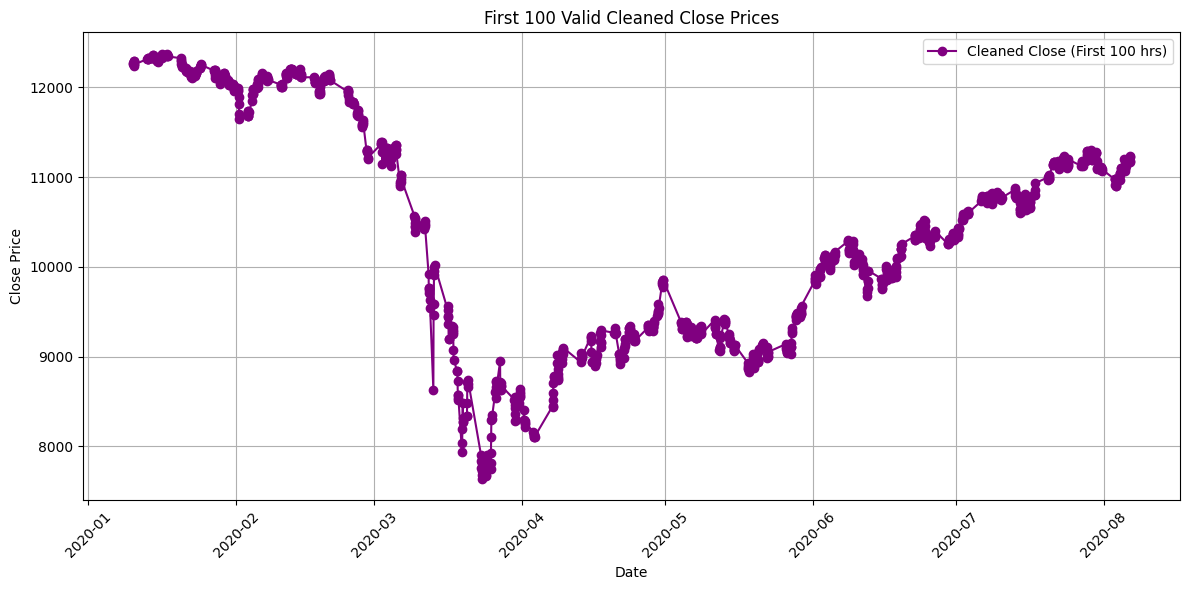

In [ ]:
import matplotlib.pyplot as plt

# Drop NaN values and take first 100 non-null entries
first_100 = df_1h['close_cleaned'].dropna().iloc[:1000]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(first_100.index, first_100.values, marker='o', linestyle='-', color='purple', label='Cleaned Close (First 100 hrs)')
plt.title('First 100 Valid Cleaned Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


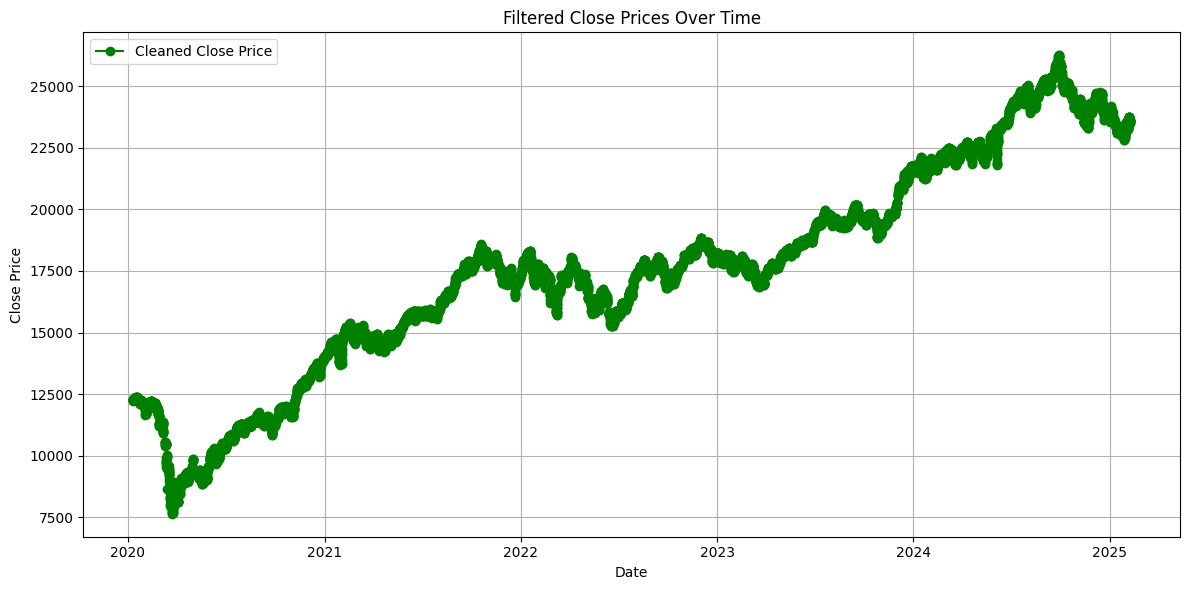

In [ ]:
import matplotlib.pyplot as plt

# Drop NaN values before plotting
cleaned = df_1h['close_cleaned'].dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cleaned.index, cleaned.values, marker='o', linestyle='-', color='green', label='Cleaned Close Price')
plt.title('Filtered Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

✅ Best Moving Average Settings:
Short MA: 5, Long MA: 30
date
2020-01-16 10:00:00   -0.00
2020-01-16 11:00:00   -0.00
2020-01-16 12:00:00    0.00
2020-01-16 13:00:00    0.00
2020-01-16 14:00:00   -0.00
                       ... 
2025-02-07 11:00:00    0.00
2025-02-07 12:00:00   -0.00
2025-02-07 13:00:00   -0.00
2025-02-07 14:00:00   -0.00
2025-02-07 15:00:00    0.00
Name: strategy_returns, Length: 8787, dtype: float64

📊 Final Performance Metrics:
Total Return (INR): ₹36,731,218.38
CAGR: 0.2745
Sharpe Ratio: 2.3661
Calmar Ratio: 3.1467
Max Drawdown: -872255.6204
Time in Drawdown: 8041.0000
Win Rate: 0.3294
Trade Frequency: 364.0000


<ipython-input-53-21056de72cd4>:90: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


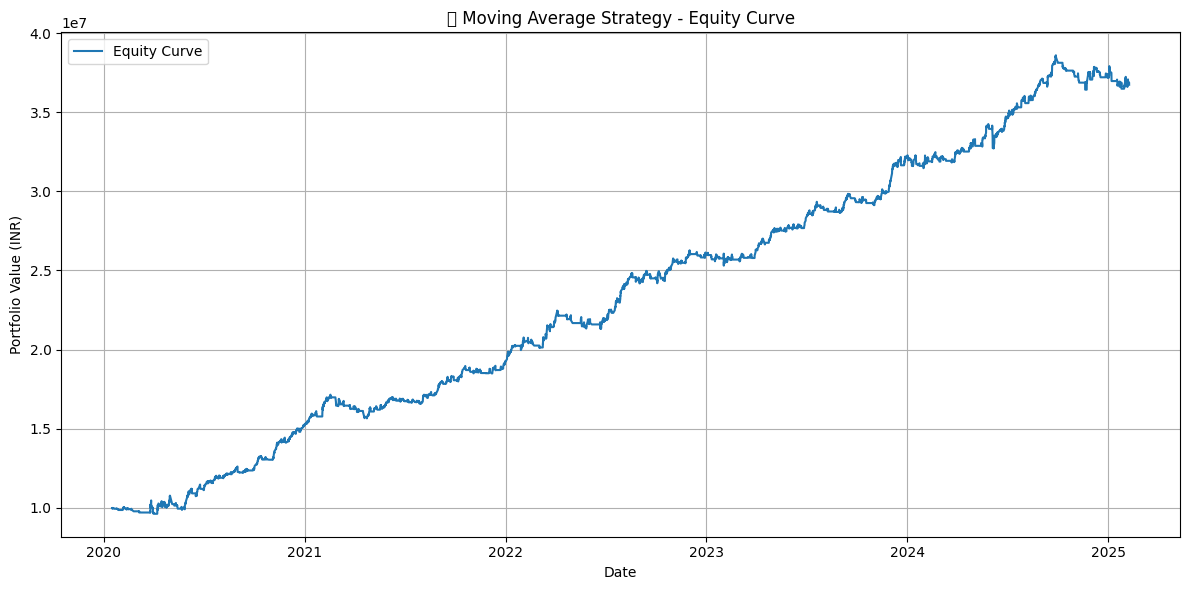

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
INITIAL_CAPITAL = 1_00_00_000  # 1 Crore INR
SLIPPAGE = 0.0001  # 0.01%
TRADING_HOURS_PER_YEAR = 252 * 6.5

# --- Strategy Function ---
def moving_average_strategy(df, short_window, long_window):
    df = df.copy()
    df['ma_short'] = df['close_cleaned'].rolling(window=short_window).mean()
    df['ma_long'] = df['close_cleaned'].rolling(window=long_window).mean()
    df['position'] = np.where(df['ma_short'] > df['ma_long'], 1, 0)
    df['position_shifted'] = df['position'].shift(1)
    df['trade'] = df['position'] - df['position_shifted']
    df['returns'] = df['close_cleaned'].pct_change()
    df['strategy_returns'] = df['returns'] * df['position']
    df['strategy_returns'] -= df['trade'].abs() * SLIPPAGE
    df['equity_curve'] = (1 + df['strategy_returns']).cumprod() * INITIAL_CAPITAL
    return df.dropna()

# --- Metric Calculation ---
def calculate_metrics(df):
    total_return = df['equity_curve'].iloc[-1]
    cagr = (df['equity_curve'].iloc[-1] / INITIAL_CAPITAL) ** (1 / (len(df) / TRADING_HOURS_PER_YEAR)) - 1
    max_drawdown = (((df['equity_curve'] / df['equity_curve'].cummax()) - 1).min())*(INITIAL_CAPITAL)
    time_in_dd = (df['equity_curve'].cummax() != df['equity_curve']).sum()
    sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(TRADING_HOURS_PER_YEAR)
    calmar = cagr / abs(max_drawdown/(INITIAL_CAPITAL)) if max_drawdown != 0 else np.nan
    win_rate = (df['strategy_returns'] > 0).sum() / df['strategy_returns'].count()
    trade_freq = df['trade'].abs().sum()

    return {
        'Total Return (INR)': total_return,
        'CAGR': cagr,
        'Sharpe Ratio': sharpe,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_drawdown,
        'Time in Drawdown': time_in_dd,
        'Win Rate': win_rate,
        'Trade Frequency': trade_freq
    }

# --- Hyperparameter Tuning ---
results = []
short_range = range(5, 51, 5)
long_range = range(30, 201, 10)

for short in short_range:
    for long in long_range:
        if short >= long:
            continue
        df_temp = moving_average_strategy(df_1h.copy(), short, long)
        metrics = calculate_metrics(df_temp)
        metrics.update({'Short MA': short, 'Long MA': long})
        results.append(metrics)

# Convert to DataFrame and pick the best
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by='Total Return (INR)', ascending=False).iloc[0]
best_short = int(best_params['Short MA'])
best_long = int(best_params['Long MA'])

print("✅ Best Moving Average Settings:")
print(f"Short MA: {best_short}, Long MA: {best_long}")


# --- Final Strategy with Best Settings ---
df_final = moving_average_strategy(df_1h.copy(), best_short, best_long)
final_metrics = calculate_metrics(df_final)
print(df_final['strategy_returns'])
# --- Display Final Metrics ---
print("\n📊 Final Performance Metrics:")
for key, value in final_metrics.items():
    if "Return" in key or "CAGR" in key:
        print(f"{key}: ₹{value:,.2f}" if "INR" in key else f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value:.4f}")

# --- Optional Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_final['equity_curve'], label='Equity Curve')
plt.title("📈 Moving Average Strategy - Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (INR)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === LOAD & PREPARE DATA ===
df2 = pd.read_csv("NIFTY BANK_minute_data.csv")
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date').sort_index()
df2 = df2.loc['2020-01-01':'2025-03-31']
df2 = df2[~df2.index.duplicated(keep='first')]

# === RESAMPLE TO 1H ===
df_1h2 = df2.resample('1h').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()
print(df_1h2)

# === SAVE TO CSV ===
df_1h2.to_csv('NIFTY 50_hourly_data.csv')

                         open      high       low     close  volume
date                                                               
2020-01-01 09:00:00 32,237.90 32,347.50 32,174.05 32,206.00       0
2020-01-01 10:00:00 32,204.20 32,207.55 32,091.45 32,106.75       0
2020-01-01 11:00:00 32,107.75 32,127.65 32,075.20 32,088.60       0
2020-01-01 12:00:00 32,088.75 32,164.25 32,058.55 32,107.05       0
2020-01-01 13:00:00 32,107.20 32,168.25 32,080.55 32,146.95       0
...                       ...       ...       ...       ...     ...
2025-02-07 11:00:00 50,297.45 50,463.60 50,272.30 50,312.60       0
2025-02-07 12:00:00 50,312.20 50,333.80 50,070.95 50,113.25       0
2025-02-07 13:00:00 50,113.00 50,180.30 49,966.45 50,018.10       0
2025-02-07 14:00:00 50,016.25 50,081.90 49,871.15 50,003.95       0
2025-02-07 15:00:00 50,002.60 50,248.35 50,000.05 50,204.35       0

[8865 rows x 5 columns]


In [ ]:
prices = df_1h2['close'].values
n = len(prices)

# allocate
cleaned = np.full(n, np.nan)

# minimum look‑back window before you trust the EMD result
min_win = 50

for t in range(min_win-1, n):
    window = prices[:t+1]                  # only data ≤ t
    # reshape for EMD_dealt: (batch=1, window_length, features=1)
    emd_proc = EMD_dealt(window.reshape(1, -1, 1), emd_type=3, imf_times=10)
    cleansed_window = emd_proc.getEmdResult().reshape(-1)
    cleaned[t] = cleansed_window[-1]       # only take today’s cleaned value

df_1h2['close_cleaned'] = cleaned

In [ ]:
df_1h2['close_cleaned'].dropna()

,close_cleaned
date,
2020-01-10 09:00:00,"32,196.50"
2020-01-10 10:00:00,"32,293.35"
2020-01-10 11:00:00,"32,292.70"
2020-01-10 12:00:00,"32,229.45"
2020-01-10 13:00:00,"32,114.45"
...,...
2025-02-07 11:00:00,"50,312.60"
2025-02-07 12:00:00,"50,113.25"
2025-02-07 13:00:00,"50,018.10"


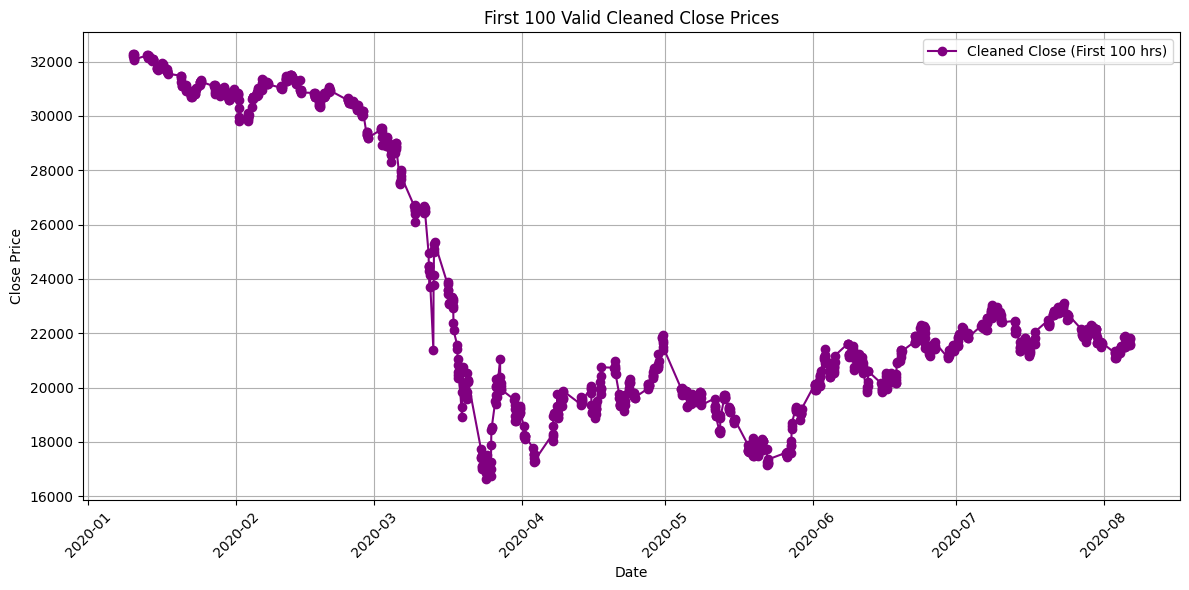

In [ ]:
import matplotlib.pyplot as plt

# Drop NaN values and take first 100 non-null entries
first_100 = df_1h2['close_cleaned'].dropna().iloc[:1000]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(first_100.index, first_100.values, marker='o', linestyle='-', color='purple', label='Cleaned Close (First 100 hrs)')
plt.title('First 100 Valid Cleaned Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

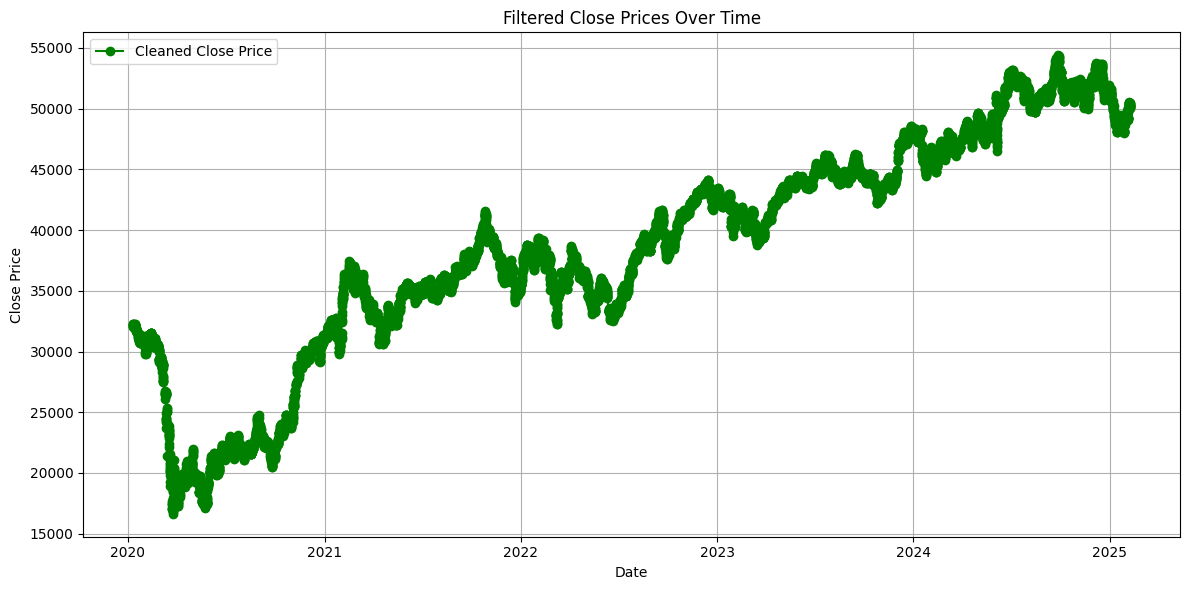

In [ ]:
import matplotlib.pyplot as plt

# Drop NaN values before plotting
cleaned = df_1h2['close_cleaned'].dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cleaned.index, cleaned.values, marker='o', linestyle='-', color='green', label='Cleaned Close Price')
plt.title('Filtered Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

✅ Best Moving Average Settings:
Short MA: 5, Long MA: 30
date
2020-01-16 10:00:00   -0.00
2020-01-16 11:00:00   -0.00
2020-01-16 12:00:00    0.00
2020-01-16 13:00:00    0.00
2020-01-16 14:00:00   -0.00
                       ... 
2025-02-07 11:00:00    0.00
2025-02-07 12:00:00   -0.00
2025-02-07 13:00:00   -0.00
2025-02-07 14:00:00   -0.00
2025-02-07 15:00:00   -0.00
Name: strategy_returns, Length: 8787, dtype: float64

📊 Final Performance Metrics:
Total Return (INR): ₹47,942,231.56
CAGR: 0.3393
Sharpe Ratio: 1.9478
Calmar Ratio: 2.0946
Max Drawdown: -1620093.6141
Time in Drawdown: 8272.0000
Win Rate: 0.2884
Trade Frequency: 384.0000


<ipython-input-62-cdd679b28df2>:90: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


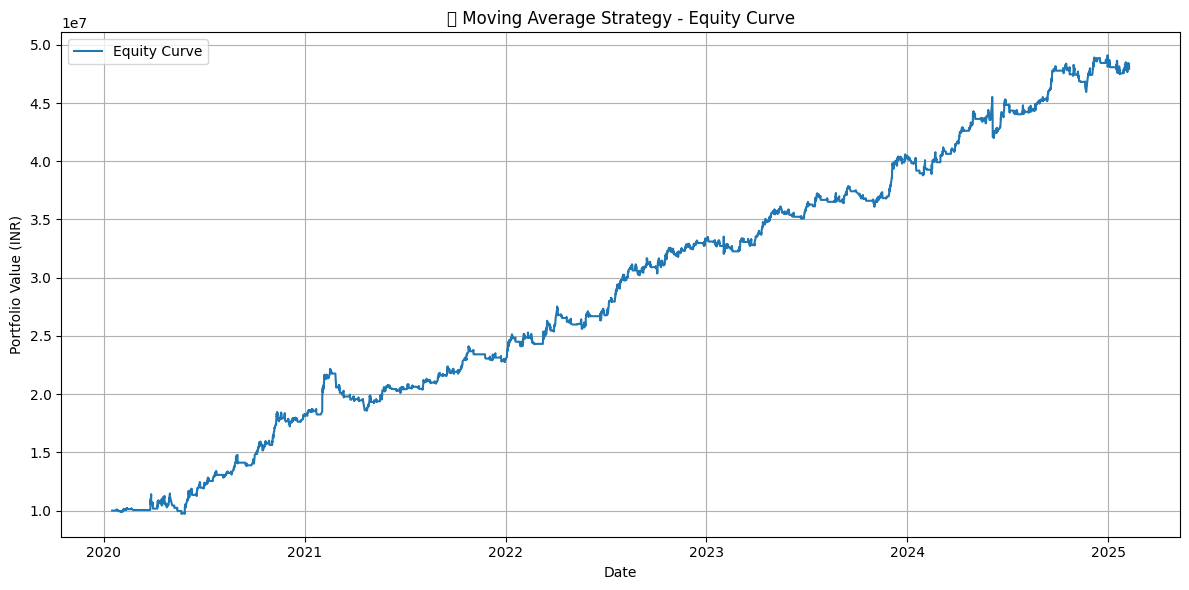

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
INITIAL_CAPITAL = 1_00_00_000  # 1 Crore INR
SLIPPAGE = 0.0001  # 0.01%
TRADING_HOURS_PER_YEAR = 252 * 6.5

# --- Strategy Function ---
def moving_average_strategy(df, short_window, long_window):
    df = df.copy()
    df['ma_short'] = df['close_cleaned'].rolling(window=short_window).mean()
    df['ma_long'] = df['close_cleaned'].rolling(window=long_window).mean()
    df['position'] = np.where(df['ma_short'] > df['ma_long'], 1, 0)
    df['position_shifted'] = df['position'].shift(1)
    df['trade'] = df['position'] - df['position_shifted']
    df['returns'] = df['close_cleaned'].pct_change()
    df['strategy_returns'] = df['returns'] * df['position']
    df['strategy_returns'] -= df['trade'].abs() * SLIPPAGE
    df['equity_curve'] = (1 + df['strategy_returns']).cumprod() * INITIAL_CAPITAL
    return df.dropna()

# --- Metric Calculation ---
def calculate_metrics(df):
    total_return = df['equity_curve'].iloc[-1]
    cagr = (df['equity_curve'].iloc[-1] / INITIAL_CAPITAL) ** (1 / (len(df) / TRADING_HOURS_PER_YEAR)) - 1
    max_drawdown = (((df['equity_curve'] / df['equity_curve'].cummax()) - 1).min())*(INITIAL_CAPITAL)
    time_in_dd = (df['equity_curve'].cummax() != df['equity_curve']).sum()
    sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(TRADING_HOURS_PER_YEAR)
    calmar = cagr / abs(max_drawdown/(INITIAL_CAPITAL)) if max_drawdown != 0 else np.nan
    win_rate = (df['strategy_returns'] > 0).sum() / df['strategy_returns'].count()
    trade_freq = df['trade'].abs().sum()

    return {
        'Total Return (INR)': total_return,
        'CAGR': cagr,
        'Sharpe Ratio': sharpe,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_drawdown,
        'Time in Drawdown': time_in_dd,
        'Win Rate': win_rate,
        'Trade Frequency': trade_freq
    }

# --- Hyperparameter Tuning ---
results = []
short_range = range(5, 51, 5)
long_range = range(30, 201, 10)

for short in short_range:
    for long in long_range:
        if short >= long:
            continue
        df_temp = moving_average_strategy(df_1h2.copy(), short, long)
        metrics = calculate_metrics(df_temp)
        metrics.update({'Short MA': short, 'Long MA': long})
        results.append(metrics)

# Convert to DataFrame and pick the best
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by='Total Return (INR)', ascending=False).iloc[0]
best_short = int(best_params['Short MA'])
best_long = int(best_params['Long MA'])

print("✅ Best Moving Average Settings:")
print(f"Short MA: {best_short}, Long MA: {best_long}")


# --- Final Strategy with Best Settings ---
df_final = moving_average_strategy(df_1h2.copy(), best_short, best_long)
final_metrics = calculate_metrics(df_final)
print(df_final['strategy_returns'])
# --- Display Final Metrics ---
print("\n📊 Final Performance Metrics:")
for key, value in final_metrics.items():
    if "Return" in key or "CAGR" in key:
        print(f"{key}: ₹{value:,.2f}" if "INR" in key else f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value:.4f}")

# --- Optional Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_final['equity_curve'], label='Equity Curve')
plt.title("📈 Moving Average Strategy - Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (INR)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
